### Data import

In [4]:
import pandas as pd
import os
import tensorflow as tf

2023-06-21 14:24:43.938237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 14:24:44.044707: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-21 14:24:44.049088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-21 14:24:44.049099: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [5]:
df1= pd.read_csv("./data/Youtube05.csv")
df2= pd.read_csv("./data/Youtube01.csv")
df3= pd.read_csv("./data/Youtube03.csv")
df4= pd.read_csv("./data/Youtube02.csv")
df5= pd.read_csv("./data/Youtube04.csv")

In [6]:
data= pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
dataset= data[["CONTENT", "CLASS"]]
comments= data[["CONTENT"]]
y_test = data["CLASS"]

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset['CONTENT'], dataset['CLASS'], test_size=0.2, random_state=42, stratify=dataset['CLASS'])

x_train = {'CONTENT': x_train,'CLASS': y_train}
x_train= pd.DataFrame(x_train)
x_test= {'CONTENT': x_test, 'CLASS': y_test}
x_test= pd.DataFrame(x_test)

### Defining labeling functions using Snorkel

In [8]:
# Possible labeling outputs defined
ABSTAIN = -1
HAM = 0
SPAM = 1

### Pattern Matching Labeling Functions

In [9]:
from snorkel.labeling import labeling_function

# check and check_out labeling functions return SPAM for texts that include those key words

@labeling_function()
def check(x):
    return SPAM if "check" in x.CONTENT.lower() else ABSTAIN


@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.CONTENT.lower() else ABSTAIN

In [10]:
import re

@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.CONTENT, flags=re.I) else ABSTAIN

In [11]:
def keyword_lookup(x, keywords, label):
    if any(word in x.CONTENT.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe", "subscribers", "sub", "subs"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

"""spam comments ask for some sort of help"""
keyword_help= make_keyword_lf(keywords=['help'])

keyword_channel= make_keyword_lf(keywords=['channel'])

### Heuristic Labeling Functions

In [12]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.CONTENT.split()) < 5 else ABSTAIN

### Third Party Model as Labeling Functions

In [13]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.CONTENT)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [14]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

### Labeling Functions with Complex Pre-Processors

In [15]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="CONTENT", doc_field="doc", memoize=True)

from snorkel.labeling.lf.nlp import nlp_labeling_function

@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

/home/amy/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-21 14:24:56.156199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-21 14:24:56.156385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-06-21 14:24:56.156423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-06-21 14:24:56.156456: W tensorflow/stream_executor/platform/default/

In [16]:
print(x_train.to_string)

<bound method DataFrame.to_string of                                                 CONTENT  CLASS
225                                           Waka waka      0
879                                     Wow dance show﻿      0
25    Nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...      0
1384  Plz help me getting 1.000 Subscribers tonight/...      1
690   If the shitty Chinese Government didn't block ...      0
...                                                 ...    ...
239                                                  :)      0
1413  Www.youniqueproducts.com/joannagordon Younique...      1
300   Hello everyone :) I know most of you probably ...      1
623   I am now going to voyage to the first comment....      0
1844  I agree they are just damn spammers. They suck...      1

[1564 rows x 2 columns]>


### Combining labeling function outputs with label model

In [17]:
lfs = [check,
    check_out,
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    keyword_help,
    keyword_channel,
    regex_check_out,
    short_comment,
    has_person,
    textblob_polarity,
    textblob_subjectivity,
]

In [18]:
from snorkel.labeling import PandasLFApplier

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=x_train)
L_test = applier.apply(df=x_test)

100%|██████████| 392/392 [00:02<00:00, 181.45it/s]


In [19]:
print(L_train)
L_train.shape

[[-1 -1 -1 ...  0 -1 -1]
 [-1 -1 -1 ... -1 -1  0]
 [-1 -1 -1 ... -1 -1  0]
 ...
 [ 1  1  1 ... -1 -1  0]
 [-1 -1  1 ... -1 -1  0]
 [-1 -1 -1 ... -1 -1 -1]]


(1564, 14)

In [20]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check,0,[1],0.245524,0.240409,0.102941
check_out,1,[1],0.205882,0.205882,0.078645
keyword_my,2,[1],0.200767,0.195652,0.123402
keyword_subscribe,3,[1],0.143223,0.126598,0.081202
keyword_http,4,[1],0.092711,0.081202,0.065857
keyword_please,5,[1],0.111893,0.107417,0.059463
keyword_song,6,[0],0.166880,0.137468,0.053708
keyword_help,7,[1],0.030691,0.028772,0.015345
keyword_channel,8,[1],0.101023,0.100384,0.056905
regex_check_out,9,[1],0.224425,0.224425,0.090793


In [21]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [22]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.502]
INFO:root:[100 epochs]: TRAIN:[loss=0.028]
 39%|███▉      | 195/500 [00:00<00:00, 1943.32epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.028]
INFO:root:[300 epochs]: TRAIN:[loss=0.028]
100%|██████████| 500/500 [00:00<00:00, 1972.29epoch/s]
INFO:root:Finished Training


In [23]:
majority_acc = majority_model.score(L=L_test, Y=y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   83.2%
Label Model Accuracy:     74.7%


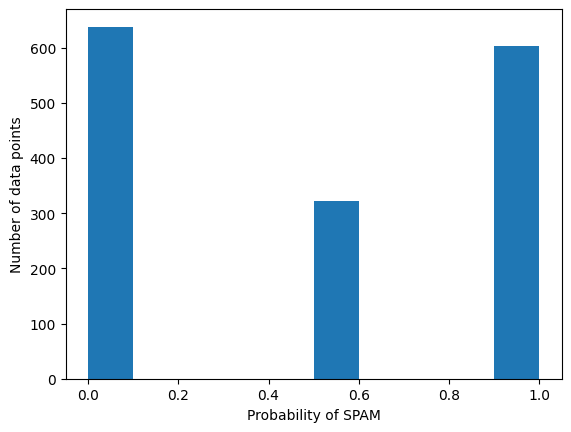

In [24]:
import matplotlib.pyplot as plt

def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = majority_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

In [25]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=x_train, y=probs_train, L=L_train
)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.CONTENT.tolist())
X_test = vectorizer.transform(x_test.CONTENT.tolist())

In [27]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [29]:
df_train_filtered['LABEL']= preds_train_filtered
df_train_filtered= df_train_filtered.reset_index(drop=True)
df_train_filtered

/tmp/ipykernel_29462/580693601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered['LABEL']= preds_train_filtered


,CONTENT,CLASS,LABEL
0,Waka waka,0,0
1,Wow dance show﻿,0,0
2,Nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...,0,0
3,Plz help me getting 1.000 Subscribers tonight/...,1,1
4,Can i get views and subscribers for no reason? 😅﻿,1,1
...,...,...,...
1386,:),0,0
1387,Www.youniqueproducts.com/joannagordon Younique...,1,0
1388,Hello everyone :) I know most of you probably ...,1,1
1389,I am now going to voyage to the first comment....,0,0


In [30]:
x_testing= x_test.reset_index(drop=True)

,CONTENT,CLASS
0,This is the only video on youtube that get so ...,0
1,I love dis song!! 3,0
2,EMINEM the best EVER.﻿,0
3,Cutie girl and beautiful song,0
4,Hey youtubers... I really appreciate all of yo...,1
...,...,...
387,How old is Katy perry?﻿,0
388,2015!! LLIKEE!!﻿,0
389,Hey guys! Please join me in my fight to help a...,1
390,waka waka:-):-):-)﻿,0


### Training an end model/classifier with weak labels

#### Training Simple Logistic Regression classifier

In [31]:
from sklearn.linear_model import LogisticRegression

# fit sklearn logistic regression model with training weak labels
sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, solver='liblinear')

In [32]:
# evaluate logistic regression model with test data
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=y_test) * 100:.1f}%")

Test Accuracy: 85.5%


#### Data cleaning

In [33]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import numpy as np
import pickle
from keras.utils import pad_sequences

[nltk_data] Downloading package stopwords to /home/amy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/amy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/amy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/amy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
# remove rows with missing values
df_train_filtered.dropna()

,CONTENT,CLASS,LABEL
0,Waka waka,0,0
1,Wow dance show﻿,0,0
2,Nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...,0,0
3,Plz help me getting 1.000 Subscribers tonight/...,1,1
4,Can i get views and subscribers for no reason? 😅﻿,1,1
...,...,...,...
1386,:),0,0
1387,Www.youniqueproducts.com/joannagordon Younique...,1,0
1388,Hello everyone :) I know most of you probably ...,1,1
1389,I am now going to voyage to the first comment....,0,0


In [35]:
# testing and training text is cleaned - removal of stopwords, links etc
def clean_text(text):
    text_cleaning_re= "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text= re.sub(text_cleaning_re, " " , str(text).lower()).strip()
    tokens= text.split()
    stop_words= set(stopwords.words('english'))
    tokens= [w for w in tokens if w not in stop_words]

    return " ".join(tokens)

In [72]:
df_train_filtered.CONTENT= df_train_filtered.CONTENT.apply(lambda x: clean_text(x))
x_testing.CONTENT= x_testing.CONTENT.apply(lambda x: clean_text(x))

In [37]:
# check for rows with missing/empty values after text cleaning
df_train_filtered.CONTENT.replace("", np.nan, inplace=True)
df_train_filtered.dropna(subset=['CONTENT'], inplace=True)
df_train_filtered

,CONTENT,CLASS,LABEL
0,waka waka,0,0
1,wow dance show,0,0
2,nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...,0,0
3,plz help getting 1 000 subscribers tonight tod...,1,1
4,get views subscribers reason,1,1
...,...,...,...
1385,awesome,0,0
1387,www youniqueproducts com joannagordon younique...,1,0
1388,hello everyone know probably pass kind comment...,1,1
1389,going voyage first comment tell family loved,0,0


In [38]:
df_train_filtered.CONTENT = df_train_filtered.CONTENT.fillna('')

In [39]:
# split each text into list of tokens
def tokenize(text):
    tokens= nltk.word_tokenize(text)
    return [w for w in tokens if w.isalpha()]

In [40]:
df_train_filtered['CONTENT']= df_train_filtered.apply(lambda x: tokenize(x['CONTENT']), axis=1)
x_testing['CONTENT']= x_testing.apply(lambda x: tokenize(x['CONTENT']), axis=1)

In [41]:
def rejoin_words(tokenized_column):
    return (" ".join(tokenized_column))

In [42]:
df_train_filtered['CONTENT']= df_train_filtered.apply(lambda x: rejoin_words(x['CONTENT']), axis=1)
x_testing['CONTENT']= x_testing.apply(lambda x: rejoin_words(x['CONTENT']), axis=1)

In [43]:
df_train_filtered

,CONTENT,CLASS,LABEL
0,waka waka,0,0
1,wow dance show,0,0
2,nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...,0,0
3,plz help getting subscribers tonight today tha...,1,1
4,get views subscribers reason,1,1
...,...,...,...
1385,awesome,0,0
1387,www youniqueproducts com joannagordon younique...,1,0
1388,hello everyone know probably pass kind comment...,1,1
1389,going voyage first comment tell family loved,0,0


In [44]:
x_testing

,CONTENT,CLASS
0,video youtube get much views want see much vie...,0
1,love dis song,0
2,eminem best ever,0
3,cutie girl beautiful song,0
4,hey youtubers really appreciate took time read...,1
...,...,...
387,old katy perry,0
388,llikee,0
389,hey guys please join fight help abused mistrea...,1
390,waka waka,0


In [73]:
# replace any missing values with nan
df_train_filtered['CONTENT'].replace('', np.nan, inplace=True)
x_testing['CONTENT'].replace('', np.nan, inplace=True)

In [46]:
# drop any rows with nan values
df_train_filtered.dropna(inplace=True)
x_testing.dropna(inplace=True)

In [47]:
# check for any remaining nan values in test and train data
df_train_filtered.isna().sum()
x_testing.isna().sum()

CONTENT    0
CLASS      0
dtype: int64

In [48]:
weak_labels= pd.get_dummies(df_train_filtered['LABEL']).values
y_test= pd.get_dummies(x_testing['CLASS']).values

In [49]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(df_train_filtered.CONTENT)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
max_length= max([len(s.split()) for s in df_train_filtered.CONTENT])

x_train= pad_sequences(tokenizer.texts_to_sequences(df_train_filtered.CONTENT), maxlen= max_length, padding= 'post', truncating= 'post')

x_test= pad_sequences(tokenizer.texts_to_sequences(x_testing.CONTENT), maxlen=max_length, padding='post', truncating='post')

word_index= tokenizer.word_index

print(x_train.shape)
print(x_test.shape)

(1336, 93)
(381, 93)


In [51]:
def load_embedding(file_name):
    file= open(file_name, 'r', encoding='utf-8')
    lines= file.readlines()
    file.close()

    embedding= dict()
    for line in lines:
        parts= line.split()
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

vocab= word_index
vocab_size= len(word_index)+ 1
embedding_dim= 100

raw_embedding= load_embedding('./data/glove.twitter.27B.100d.txt')

In [52]:
def get_weight_matrix(embedding, vocab):
    vocab_size= len(vocab)+1
    weight_matrix= np.zeros((vocab_size, embedding_dim))

    for word, i in vocab.items():
        vector= embedding.get(word)
        if vector is not None:
            weight_matrix[i]= vector
    return weight_matrix

embedding_matrix= get_weight_matrix(raw_embedding, vocab)

#### Training Bi-LSTM

#### Bi-LSTM with and without pre-trained embedding weights

In [53]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Embedding, LSTM, SpatialDropout1D, Bidirectional
from keras.layers.core import Dense, Dropout

In [54]:
embedding_layer= Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)

In [55]:
biLSTM= Sequential()
biLSTM.add(embedding_layer)
biLSTM.add(Bidirectional(LSTM(64, return_sequences=True)))
biLSTM.add(Bidirectional(LSTM(64)))
biLSTM.add(Dense(32))
biLSTM.add(Dense(32))
biLSTM.add(Dense(32))
biLSTM.add(Dense(2, activation= 'sigmoid'))

biLSTM.summary()

2023-06-21 14:25:59.067307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 93, 100)           274600    
                                                                 
 bidirectional (Bidirectiona  (None, 93, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1

In [56]:
Batch_size= 32
epochs=10

biLSTM.compile(loss= 'binary_crossentropy', optimizer= 'Adam', metrics= 'accuracy')

In [57]:
history= biLSTM.fit(x_train, weak_labels, batch_size= Batch_size, epochs=10, verbose=1)

Epoch 1/10
42/42 [==============================] - 11s 161ms/step - loss: 0.4224 - accuracy: 0.8121
Epoch 2/10
42/42 [==============================] - 6s 153ms/step - loss: 0.2487 - accuracy: 0.9154
Epoch 3/10
42/42 [==============================] - 6s 149ms/step - loss: 0.2046 - accuracy: 0.9266
Epoch 4/10
42/42 [==============================] - 6s 151ms/step - loss: 0.1833 - accuracy: 0.9356
Epoch 5/10
42/42 [==============================] - 7s 156ms/step - loss: 0.1497 - accuracy: 0.9499
Epoch 6/10
42/42 [==============================] - 7s 163ms/step - loss: 0.1308 - accuracy: 0.9543
Epoch 7/10
42/42 [==============================] - 7s 169ms/step - loss: 0.1254 - accuracy: 0.9581
Epoch 8/10
42/42 [==============================] - 7s 162ms/step - loss: 0.1033 - accuracy: 0.9641
Epoch 9/10
42/42 [==============================] - 7s 163ms/step - loss: 0.1012 - accuracy: 0.9656
Epoch 10/10
42/42 [==============================] - 7s 164ms/step - loss: 0.0836 - accuracy: 0.967

In [58]:
results= biLSTM.evaluate(x_test, y_test)

12/12 [==============================] - 1s 41ms/step - loss: 0.4524 - accuracy: 0.8766


In [59]:
biLSTM2= Sequential()
biLSTM2.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
biLSTM2.add(Bidirectional(LSTM(64, return_sequences=True)))
biLSTM2.add(Bidirectional(LSTM((64))))
biLSTM2.add(Dense(32))
biLSTM2.add(Dense(32))
biLSTM2.add(Dense(32))
biLSTM2.add(Dense(2, activation= 'sigmoid'))

biLSTM2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 93, 100)           274600    
                                                                 
 bidirectional_2 (Bidirectio  (None, 93, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)               

In [60]:
biLSTM2.compile(loss='binary_crossentropy', optimizer='Adam', metrics= ['accuracy'])

In [61]:
history2= biLSTM2.fit(x_train, weak_labels, batch_size= Batch_size, epochs=10, verbose=1)

Epoch 1/10
42/42 [==============================] - 9s 126ms/step - loss: 0.5059 - accuracy: 0.7395
Epoch 2/10
42/42 [==============================] - 5s 125ms/step - loss: 0.1691 - accuracy: 0.9341
Epoch 3/10
42/42 [==============================] - 7s 164ms/step - loss: 0.0766 - accuracy: 0.9746
Epoch 4/10
42/42 [==============================] - 7s 164ms/step - loss: 0.0424 - accuracy: 0.9828
Epoch 5/10
42/42 [==============================] - 7s 162ms/step - loss: 0.0336 - accuracy: 0.9850
Epoch 6/10
42/42 [==============================] - 7s 165ms/step - loss: 0.0240 - accuracy: 0.9888
Epoch 7/10
42/42 [==============================] - 7s 167ms/step - loss: 0.0257 - accuracy: 0.9925
Epoch 8/10
42/42 [==============================] - 7s 163ms/step - loss: 0.0224 - accuracy: 0.9925
Epoch 9/10
42/42 [==============================] - 7s 165ms/step - loss: 0.0162 - accuracy: 0.9948
Epoch 10/10
42/42 [==============================] - 7s 163ms/step - loss: 0.0147 - accuracy: 0.9940

In [62]:
results2= biLSTM.evaluate(x_test, y_test)

12/12 [==============================] - 0s 33ms/step - loss: 0.4524 - accuracy: 0.8766


#### Training BERT

In [63]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [65]:
bert_preprocess= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [66]:
text_input= tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text= bert_preprocess(text_input)
outputs= bert_encoder(preprocessed_text)

In [67]:
x = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
x = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(x)

In [68]:
model = tf.keras.Model(inputs=[text_input], outputs = [x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [69]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [70]:
X_train= df_train_filtered['CONTENT']
Y_train= df_train_filtered['LABEL']

model.fit(x=X_train, y=Y_train, epochs=20)

Epoch 1/20


42/42 [==============================] - 117s 3s/step - loss: 0.6994 - accuracy: 0.5240
Epoch 2/20
42/42 [==============================] - 112s 3s/step - loss: 0.6423 - accuracy: 0.6385
Epoch 3/20
42/42 [==============================] - 111s 3s/step - loss: 0.5982 - accuracy: 0.7193
Epoch 4/20
42/42 [==============================] - 113s 3s/step - loss: 0.5787 - accuracy: 0.7463
Epoch 5/20
42/42 [==============================] - 111s 3s/step - loss: 0.5519 - accuracy: 0.7582
Epoch 6/20
42/42 [==============================] - 122s 3s/step - loss: 0.5370 - accuracy: 0.7777
Epoch 7/20
42/42 [==============================] - 123s 3s/step - loss: 0.5291 - accuracy: 0.7740
Epoch 8/20
42/42 [==============================] - 125s 3s/step - loss: 0.5091 - accuracy: 0.7837
Epoch 9/20
42/42 [==============================] - 138s 3s/step - loss: 0.5223 - accuracy: 0.7605
Epoch 10/20
42/42 [==============================] - 132s 3s/step - loss: 0.5017 - accuracy: 0.7695
Epoch 11/20
42/42 [=

In [71]:
X_test= x_testing['CONTENT']
Y_test= x_testing['CLASS']

model.evaluate(X_test, Y_test)

12/12 [==============================] - 32s 3s/step - loss: 0.4212 - accuracy: 0.8294


[0.4212155342102051, 0.8293963074684143]